In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib

import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

from counterfactuals.datasets.file_dataset import FileDataset
from counterfactuals.metrics.metrics import evaluate_cf
from counterfactuals.models import LogisticRegression, MaskedAutoregressiveFlow

AReS = getattr(
    importlib.import_module("counterfactuals.cf_methods.global.ares.ares"),
    "AReS",
)
GLOBE_CE = getattr(
    importlib.import_module("counterfactuals.cf_methods.global.globe_ce.globe_ce"),
    "GLOBE_CE",
)

/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class NotebookMoonsDataset(FileDataset):
    """Dataset helper with scaling and dataloaders for the notebook."""

    def __init__(self, config_path: str):
        super().__init__(config_path=config_path)
        self.features = [*self.config.features, self.config.target]

        self.X_unscaled = self.X.astype(np.float32)
        self.X_train_unscaled = self.X_train.astype(np.float32)
        self.X_test_unscaled = self.X_test.astype(np.float32)

        self.feature_transformer = MinMaxScaler()
        self.X_train = self.feature_transformer.fit_transform(self.X_train_unscaled)
        self.X_test = self.feature_transformer.transform(self.X_test_unscaled)
        self.X = self.feature_transformer.transform(self.X_unscaled)

        self.y_train = self.y_train.astype(np.int64)
        self.y_test = self.y_test.astype(np.int64)

        self.categorical_features = list(self.config.categorical_features)
        self.numerical_features = list(self.config.continuous_features)
        index_lookup = {name: idx for idx, name in enumerate(self.config.features)}
        self.categorical_features_indices = [
            index_lookup[name] for name in self.categorical_features
        ]
        self.numerical_features_indices = [index_lookup[name] for name in self.numerical_features]
        self.categorical_columns = self.categorical_features_indices
        self.numerical_columns = self.numerical_features_indices

        self.features_tree = {name: [] for name in self.config.features}
        self.bins = {}
        self.bins_tree = {}
        self.n_bins = None

    def _build_dataset(self, split: str, noise: float = 0.0) -> TensorDataset:
        features = getattr(self, f"X_{split}")
        labels = getattr(self, f"y_{split}")
        values = (
            features
            if noise == 0.0
            else np.clip(
                features + np.random.normal(scale=noise, size=features.shape),
                0.0,
                1.0,
            )
        )
        tensor_x = torch.tensor(values, dtype=torch.float32)
        tensor_y = torch.tensor(labels, dtype=torch.float32)
        return TensorDataset(tensor_x, tensor_y)

    def train_dataloader(
        self, batch_size: int, shuffle: bool, noise_lvl: float = 0.0
    ) -> DataLoader:
        return DataLoader(
            self._build_dataset("train", noise_lvl),
            batch_size=batch_size,
            shuffle=shuffle,
        )

    def test_dataloader(self, batch_size: int, shuffle: bool) -> DataLoader:
        return DataLoader(
            self._build_dataset("test"),
            batch_size=batch_size,
            shuffle=shuffle,
        )

In [4]:
dataset = NotebookMoonsDataset(config_path="../config/datasets/moons.yaml")
dataset.X_train.shape, dataset.X_test.shape

((800, 2), (200, 2))

In [5]:
num_features = dataset.X_train.shape[1]

disc_model = LogisticRegression(num_inputs=num_features, num_targets=1)
disc_model.load("../models/MoonsDataset/fold_0/disc_model_LogisticRegression.pt")

gen_model = MaskedAutoregressiveFlow(
    features=num_features,
    hidden_features=16,
    context_features=1,
    num_layers=8,
    num_blocks_per_layer=4,
)
gen_model.load(
    "../models/MoonsDataset/fold_0/gen_model_MaskedAutoregressiveFlow_relabeled_by_LogisticRegression.pt"
)

In [6]:
for split_name in ("train", "test"):
    features = getattr(dataset, f"X_{split_name}")
    relabeled = disc_model.predict(features).astype(np.int64)
    setattr(dataset, f"y_{split_name}", relabeled)

train_loader = dataset.train_dataloader(batch_size=1024, shuffle=True)
test_loader = dataset.test_dataloader(batch_size=1024, shuffle=False)

In [7]:
raw_train = dataset.X_train_unscaled
raw_test = dataset.X_test_unscaled
combined_df = pd.DataFrame(
    np.vstack([raw_train, raw_test]),
    columns=dataset.config.features,
)


def predict_fn(unscaled: np.ndarray) -> np.ndarray:
    transformed = dataset.feature_transformer.transform(unscaled.astype(np.float32))
    return disc_model.predict(transformed)


ares_helper = AReS(
    predict_fn=predict_fn,
    dataset=dataset,
    X=combined_df,
    dropped_features=[],
    n_bins=10,
    ordinal_features=[],
    normalise=False,
    constraints=[20, 7, 10],
)
bin_widths = ares_helper.bin_widths

/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [8]:
test_predictions = predict_fn(raw_test)
eligible_mask = test_predictions != 1
raw_candidates = pd.DataFrame(
    raw_test[eligible_mask],
    columns=dataset.config.features,
)

globe_ce = GLOBE_CE(
    predict_fn=predict_fn,
    dataset=dataset,
    X=raw_candidates,
    bin_widths=bin_widths,
)
counterfactuals_unscaled = globe_ce.explain()
counterfactuals_scaled = dataset.feature_transformer.transform(counterfactuals_unscaled)
pd.DataFrame(counterfactuals_unscaled, columns=dataset.config.features).head()

/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
100%|██████████| 1000/1000 [00:00<00:00, 20383.16it/s]


Unable to find recourse for 0/100 inputs


,0,1
0,-0.691049,-0.045350
1,-0.819773,-0.080004
2,-0.220907,0.081418
3,0.770937,0.347893
4,-0.410467,0.030262


In [9]:
log_prob_loader = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_values = gen_model.predict_log_prob(log_prob_loader)
log_prob_threshold = torch.quantile(log_prob_values, 0.25)

original_samples = dataset.X_test[eligible_mask]
original_labels = test_predictions[eligible_mask]
target_labels = np.abs(original_labels - 1)
success_mask = np.ones(counterfactuals_scaled.shape[0], dtype=bool)

metrics = evaluate_cf(
    gen_model=gen_model,
    disc_model=disc_model,
    X_cf=counterfactuals_scaled,
    model_returned=success_mask,
    categorical_features=dataset.categorical_features_indices,
    continuous_features=dataset.numerical_features_indices,
    X_train=dataset.X_train,
    y_train=dataset.y_train.reshape(-1),
    X_test=original_samples,
    y_test=original_labels,
    y_target=target_labels,
    median_log_prob=log_prob_threshold,
    metrics_conf_path="../counterfactuals/pipelines/conf/metrics/default.yaml",
)

2025-10-13 16:14:27,194 - counterfactuals.metrics.orchestrator - INFO - Initialized MetricsOrchestrator with 100 counterfactuals, 99 valid


In [10]:
metrics

{'coverage': 1.0,
 'validity': 0.99,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': 0.23244068429527634,
 'proximity_categorical_jaccard': 0.23244068429527634,
 'proximity_continuous_manhattan': 0.28322517905559663,
 'proximity_continuous_euclidean': 0.23244068429527634,
 'proximity_continuous_mad': 1.3941817869956683,
 'proximity_l2_jaccard': 0.23244068429527634,
 'proximity_mad_hamming': 1.3941817869956683,
 'prob_plausibility': 0.0,
 'log_density_cf': -0.4556483,
 'log_density_test': 1.3799455,
 'lof_scores_cf': 1.3463260061397864,
 'lof_scores_test': 1.0635225,
 'isolation_forest_scores_cf': -0.007299261496983305,
 'isolation_forest_scores_test': 0.00467815737879435}

/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


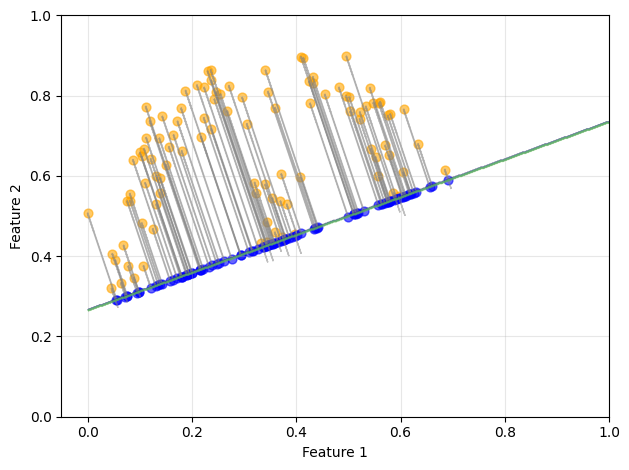

In [11]:
from counterfactuals.plotting.counterfactual_visualization import plot_counterfactuals

plot_counterfactuals(counterfactuals_scaled, original_samples, None, disc_model)